In [648]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os.path as osp
import sys

In [274]:
#sys.path.insert(0, "/usr/users/vogg/FairMOT/own_ideas/")
#sys.path

['/usr/users/vogg/FairMOT/own_ideas/',
 '/usr/users/vogg/FairMOT/DCNv2',
 '/opt/conda/envs/FairMOT/src/lib/',
 '/opt/conda/envs/FairMOT/src/',
 '/opt/conda/envs/FairMOT',
 '/opt/conda/envs/FairMOT/lib/python3.8/site-packages',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/vogg/.ipython']

In [649]:
import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

from lib.opts import opts
from lib.tracking_utils.utils import mkdir_if_missing
from lib.tracking_utils.log import logger
import lib.datasets.dataset.jde as datasets
from track import eval_seq

In [256]:
os.getcwd()

'/usr/users/vogg/FairMOT/own_ideas'

In [650]:
def read_gt_results(filename):
    """
    Input: .txt or .csv file containing labeled from VoTT
    """
    results_dict = dict()
    if os.path.isfile(filename):
        fid = 0
        frid_prior = ""
        with open(filename, 'r') as f:
            next(f)
            for line in f.readlines():
                linelist = line.split(',')
                frid = linelist[0]
                if frid != frid_prior:
                    fid = fid + 2
                frid_prior = frid    
                    
                results_dict.setdefault(fid, list())
                
                #convert xmin, ymin, xmax, ymax to tlwh
                linelist[3] = float(linelist[3]) - float(linelist[1])
                linelist[4] = float(linelist[4]) - float(linelist[2])
                box_size = float(linelist[3]) * float(linelist[4])
                
                score = float(1)
                
                tlwh = tuple(map(float, linelist[1:5]))
                target_id = int(linelist[5].split('"')[1])
                results_dict[fid].append((tlwh, target_id, score))

    return results_dict

gt_results = read_gt_results("/usr/users/vogg/test/Validation-export.csv")
#gt_results[4]

In [542]:
#Models
# Train mcqpose only
# Train OMS only
# Train OMS + Mcqpose
# Train Mcqpose + OMS
#mcqpose_ft_dla34.pth
#oms_ft_dla34.pth

#conf_thres

In [651]:
def read_mot_results(filename):
    results_dict = dict()
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                linelist = line.split(',')
                fid = int(linelist[0])
                if fid < 1:
                    continue
                results_dict.setdefault(fid, list())

                box_size = float(linelist[4]) * float(linelist[5])
                
                score = float(linelist[6])

                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])

                results_dict[fid].append((tlwh, target_id, score))

    return results_dict

In [659]:
models = ['mcq'+ str(elem) for elem in list(range(20,301,20))] + \
['oms' + str(elem) for elem in [2,4,6]] + \
['mcq' + str(elem) + 'oms2' for elem in list(range(10,121,10))] + \
['mcqcp' + str(elem) for elem in list(range(10,221,10))]

#print(models)

In [660]:
accs = []

for i in models:
    results = read_mot_results("/usr/users/vogg/FairMOT/videos/" + i + "/results.txt")
    #get every second frame to compare to labeled video
    mot_results = { your_key: results.get(your_key, results.get(your_key + 1))
                   for your_key in range(2,330,2) }

    acc = mm.MOTAccumulator(auto_id = True)

    for frame_id in range(2, 330, 2):

        gt_objs = gt_results.get(frame_id, [])
        gt_tlwhs, gt_ids, _ = zip(*gt_objs)

        trk_objs = mot_results.get(frame_id, [])
        trk_tlwhs, trk_ids, _ = zip(*trk_objs)

        iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
        acc.update(gt_ids, trk_ids, iou_distance)

        metrics=('mota', 'num_switches', 'idp', 'idr', 'idf1', 'precision', 'recall')
        mh = mm.metrics.create()

    accs.append(acc)

In [661]:
summary = mh.compute_many(
            accs,
            metrics=metrics,
            names=models,
            generate_overall=True
        )

summary['type'] = summary.index.str.replace("[0-9]", "")
summary['epoch'] = summary.index.str.replace("\D|2$","")
mapping = {'mcq': 1, 'mcqcp': 2, 'oms': 3, 'mcqoms': 4}
typecol = [mapping[letter] for letter in summary.type.values[:-1]]
summary

<ipython-input-661-f5225220963a>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  summary['type'] = summary.index.str.replace("[0-9]", "")
<ipython-input-661-f5225220963a>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  summary['epoch'] = summary.index.str.replace("\D|2$","")


,mota,num_switches,idp,idr,idf1,precision,recall,type,epoch
mcq20,0.484118,17,0.679466,0.445783,0.538360,0.883139,0.579409,mcq,20
mcq40,0.568456,30,0.670922,0.518072,0.584672,0.889362,0.686747,mcq,40
mcq60,0.570646,27,0.663488,0.533406,0.591378,0.873297,0.702081,mcq,60
mcq80,0.524644,43,0.620056,0.480832,0.541641,0.868644,0.673604,mcq,80
mcq100,0.576123,28,0.694293,0.559693,0.619770,0.876359,0.706462,mcq,100
mcq120,0.585980,23,0.652355,0.515882,0.576147,0.886427,0.700986,mcq,120
mcq140,0.460022,12,0.875527,0.454545,0.598414,0.955696,0.496166,mcq,140
mcq160,0.617744,17,0.678014,0.523549,0.590853,0.912057,0.704272,mcq,160
mcq180,0.640745,11,0.745014,0.572837,0.647678,0.924501,0.710843,mcq,180
mcq200,0.610077,38,0.657931,0.522453,0.582418,0.910345,0.722892,mcq,200


116

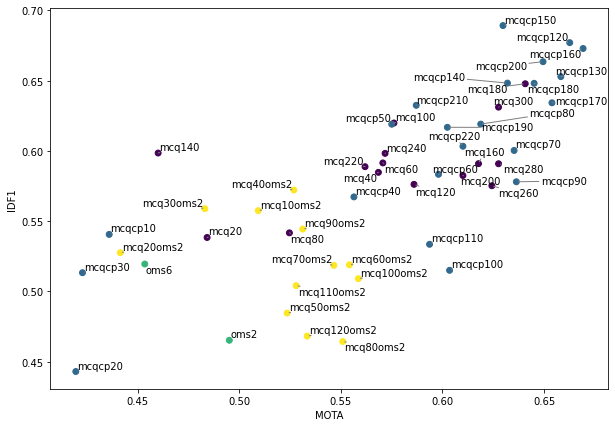

In [656]:
fig, ax = plt.subplots(figsize=(10, 7))



# Set the color map to match the number of species

ax.scatter(summary.mota[:-1], summary.idf1[:-1], s = 35, c = typecol)
ax.set_xlabel("MOTA")
ax.set_ylabel("IDF1")

texts = [plt.text(summary.mota[i], summary.idf1[i], summary.index[i]) for i in range(len(summary.index[:-1]))]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))


Text(0, 0.5, 'MOTA')

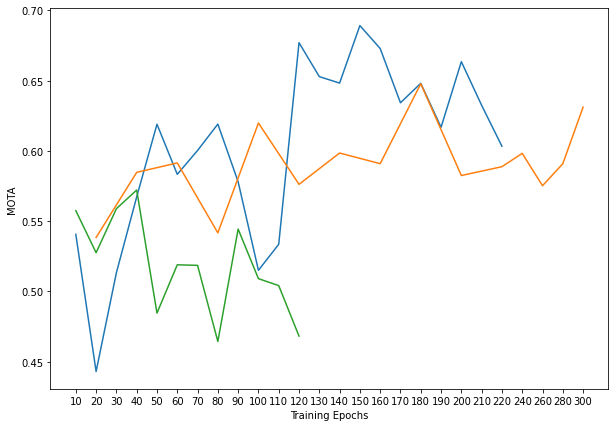

In [657]:
subset1 = summary[summary.type == "mcqcp"]
subset2 = summary[summary.type == "mcq"]
subset3 = summary[summary.type == "mcqoms"]

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(subset1.epoch, subset1.idf1)
ax.plot(subset2.epoch, subset2.idf1)
ax.plot(subset3.epoch, subset3.idf1)
ax.set_xlabel("Training Epochs")
ax.set_ylabel("MOTA")

In [658]:
subset1

,mota,num_switches,idp,idr,idf1,precision,recall,type,epoch
mcqcp10,0.435926,38,0.634218,0.470975,0.540541,0.821534,0.610077,mcqcp,10
mcqcp20,0.419496,25,0.626000,0.342826,0.443029,0.908000,0.497262,mcqcp,20
mcqcp30,0.422782,22,0.746862,0.391019,0.513300,0.926778,0.485214,mcqcp,30
mcqcp40,0.556407,32,0.645251,0.506024,0.567219,0.877095,0.687842,mcqcp,40
mcqcp50,0.575027,27,0.709632,0.548740,0.618901,0.890935,0.688938,mcqcp,50
mcqcp60,0.598028,18,0.670940,0.515882,0.583282,0.901709,0.693319,mcqcp,60
mcqcp70,0.635268,25,0.668910,0.544359,0.600242,0.907133,0.738226,mcqcp,70
mcqcp80,0.618839,10,0.733133,0.535597,0.618987,0.931034,0.680175,mcqcp,80
mcqcp90,0.636364,14,0.664296,0.511501,0.577970,0.923186,0.710843,mcqcp,90
mcqcp100,0.603505,36,0.569721,0.469880,0.515006,0.889774,0.733844,mcqcp,100


## Thresholds

We have three thresholds which can be tuned for a better detection / tracking result. We will tweak them with the currently best model mcq180.pth to see if we can improve performance even further.
- Confidence threshold: From the heatmap + width/height, a confidence for the bounding box is calculated (how exactly?) - with the confidence threshold we can filter out more or less boxes.
- Embedding similarity threshold: When a new frame is analyzed we look at the embedding of the center point of an object. Then we compare this embedding to all the embeddings of center points of objects in prior frames and match them if they are closer than this threshold.
- IoU similarity threshold: Same as embedding similarity threshold, but now with IoU between current detections and detections in prior frames.

In [552]:
combs = []

for c in [0.02, 0.04, 0.06, 0.08, "0.10", 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for e in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
        for i in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
            combs.append("mcq180_"+str(c)+"_"+str(e)+"_"+str(i))

In [553]:
accs = []

results_root = "/usr/users/vogg/FairMOT/videos/thres/"

for c in [0.02, 0.04, 0.06, 0.08, "0.10", 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for e in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
        for i in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
            results = read_mot_results(results_root + "mcq180_" + str(c) + "_" + str(e) + "_" + str(i) + "/results.txt")
            #get every second frame to compare to labeled video
            mot_results = { your_key: results.get(your_key, results.get(your_key + 1))
                           for your_key in range(2,330,2) }
            
            acc = mm.MOTAccumulator(auto_id = True)

            for frame_id in range(2, 330, 2):

                gt_objs = gt_results.get(frame_id, [])
                gt_tlwhs, gt_ids, _ = zip(*gt_objs)

                trk_objs = mot_results.get(frame_id, [])
                trk_tlwhs, trk_ids, _ = zip(*trk_objs)

                iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
                acc.update(gt_ids, trk_ids, iou_distance)

                metrics=('mota', 'num_switches', 'idp', 'idr', 'idf1', 'precision', 'recall')
                mh = mm.metrics.create()

            accs.append(acc)
    print(c)

0.02
0.04
0.06
0.08
0.10
0.15
0.2
0.3
0.4
0.5
0.6
0.7


In [554]:
import pandas as pd

summary = mh.compute_many(
            accs,
            metrics=metrics,
            names=combs,
            generate_overall=True
        )

summary = summary.iloc[:-1,:]

summary['index1'] = summary.index

summary['confidence'] = summary['index1'].str.split("_").map(lambda x: x[1]).astype(float)
summary['embedding_sim'] = summary['index1'].str.split("_").map(lambda x: x[2]).astype(float)
summary['iou_sim'] = summary['index1'].str.split("_").map(lambda x: x[3]).astype(float)

summary = summary.drop(columns = ['index1'])

In [555]:
summary[summary.mota > 0.665]

,mota,num_switches,idp,idr,idf1,precision,recall,confidence,embedding_sim,iou_sim
mcq180_0.06_0.4_0.4,0.668127,17,0.713188,0.610077,0.657615,0.901408,0.771084,0.06,0.4,0.4
mcq180_0.06_0.4_0.6,0.665936,15,0.715924,0.615553,0.661955,0.896815,0.771084,0.06,0.4,0.6
mcq180_0.06_0.4_0.7,0.665936,15,0.715924,0.615553,0.661955,0.896815,0.771084,0.06,0.4,0.7
mcq180_0.06_0.5_0.4,0.670318,19,0.711367,0.610077,0.656840,0.902937,0.774370,0.06,0.5,0.4
mcq180_0.06_0.5_0.6,0.665936,17,0.715924,0.615553,0.661955,0.898089,0.772180,0.06,0.5,0.6
mcq180_0.06_0.5_0.7,0.665936,17,0.715924,0.615553,0.661955,0.898089,0.772180,0.06,0.5,0.7
mcq180_0.06_0.6_0.4,0.668127,21,0.736976,0.635268,0.682353,0.900889,0.776561,0.06,0.6,0.4
mcq180_0.08_0.4_0.4,0.667032,16,0.718547,0.606791,0.657957,0.905318,0.764513,0.08,0.4,0.4
mcq180_0.08_0.5_0.4,0.668127,20,0.647287,0.548740,0.593954,0.906977,0.768894,0.08,0.5,0.4
mcq180_0.08_0.6_0.4,0.667032,19,0.630491,0.534502,0.578542,0.905685,0.767798,0.08,0.6,0.4


In [442]:
summary[summary.num_switches < 10]

,mota,num_switches,idp,idr,idf1,precision,recall,confidence,embedding_sim,iou_sim
mcq180_0.6_0.4_0.5,0.628697,8,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.4,0.5
mcq180_0.6_0.4_0.6,0.627601,9,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.4,0.6
mcq180_0.6_0.4_0.7,0.627601,9,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.4,0.7
mcq180_0.6_0.5_0.4,0.625411,9,0.735821,0.539978,0.622868,0.932836,0.684556,0.6,0.5,0.4
mcq180_0.6_0.5_0.5,0.629792,7,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.5,0.5
mcq180_0.6_0.5_0.6,0.629792,7,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.5,0.6
mcq180_0.6_0.5_0.7,0.629792,7,0.741018,0.542169,0.626186,0.935629,0.684556,0.6,0.5,0.7
mcq180_0.7_0.5_0.4,0.607886,8,0.738863,0.526835,0.615090,0.932412,0.664841,0.7,0.5,0.4
mcq180_0.7_0.5_0.5,0.612267,6,0.744222,0.529025,0.618438,0.935285,0.664841,0.7,0.5,0.5
mcq180_0.7_0.5_0.6,0.612267,6,0.744222,0.529025,0.618438,0.935285,0.664841,0.7,0.5,0.6


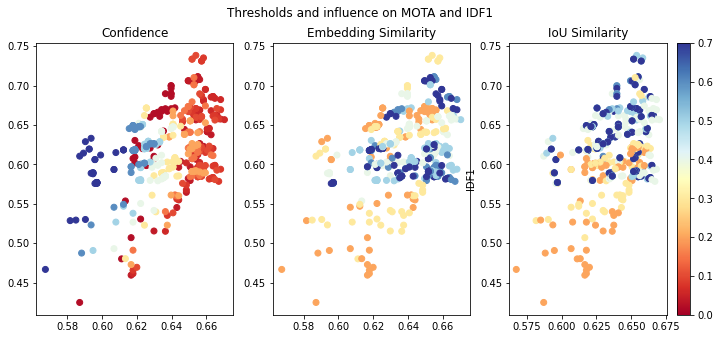

In [490]:
cm = plt.cm.get_cmap('RdYlBu')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,5))
fig.suptitle('Thresholds and influence on MOTA and IDF1')

ax1.scatter(summary.mota, summary.idf1, 
                 c = summary.confidence, cmap=cm, vmin = 0)
ax1.set_title("Confidence")

ax2.scatter(summary.mota, summary.idf1, 
                 c = summary.embedding_sim, cmap=cm, vmin = 0)
ax2.set_title("Embedding Similarity")

cm = ax3.scatter(summary.mota, summary.idf1, 
                 c = summary.iou_sim, cmap=cm, vmin = 0)
ax3.set_ylabel("IDF1")
ax3.set_title("IoU Similarity")

plt.colorbar(cm)

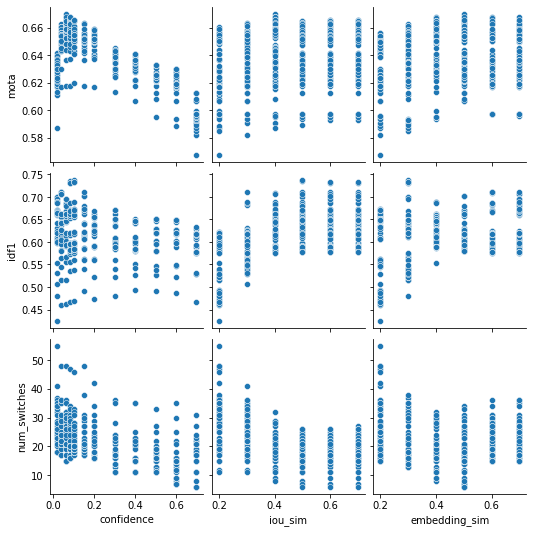

In [450]:
import seaborn as sns

a = sns.pairplot(summary,
                x_vars = ['confidence', 'iou_sim', 'embedding_sim'],
                y_vars = ['mota', 'idf1', 'num_switches'])